In [1]:
!pip install keras_multi_head

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras_multi_head: filename=keras_multi_head-0.29.0-py3-none-any.whl size=14977 sha256=329e99613522c79f18cd080dd83f2adcd5e426d6c1fdba8921c36f8c527eef36
  Stored in directory: /root/.cache/pip/wheels/cb/23/4b/06d7ae21714f70fcc25b48f972cc8e5e7f4b6b764a038b509d
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=e9f81463b4c5c61f45623bb4ba1090d714021806adb825ba8182eb40f73ea65b
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_multi_head keras-self-attention


### Importing Required Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import keras
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.callbacks import ReduceLROnPlateau
from tqdm import tqdm
from keras_multi_head import MultiHead
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop
from keras.models import Sequential, load_model
from keras.layers import  (Reshape,
                          LSTM, 
                          Dense, 
                          Conv1D, 
                          MaxPooling1D, 
                          Flatten, 
                          Dropout, 
                          BatchNormalization,
                          LSTM,
                          TimeDistributed,
                          Bidirectional)
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from pydub import AudioSegment
from keras.models import load_model
from keras.models import Model
import xgboost as xgb

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### To Use GPU 

In [3]:
# making use of the GPU
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Use GPU 0

### Feature Extraction

In [4]:
Features = pd.read_csv('/kaggle/input/features-final/Features_final.csv')
labels=Features['labels']
# print(labels)
data= Features.drop('labels',axis= 1)
encoder = OneHotEncoder()
labels = encoder.fit_transform(np.array(labels).reshape(-1,1)).toarray()

# Get the encoding dictionary
encoding_dict = {label: encoded_value for label, encoded_value in zip(encoder.get_feature_names_out(['labels']), encoder.categories_[0])}

print("Encoding Dictionary:")
print(encoding_dict)

Encoding Dictionary:
{'labels_angry': 'angry', 'labels_disgust': 'disgust', 'labels_fear': 'fear', 'labels_happy': 'happy', 'labels_neutral': 'neutral', 'labels_sad': 'sad', 'labels_surprise': 'surprise'}


In [5]:
import joblib
joblib.dump(encoder, 'your_encoder.joblib')

['your_encoder.joblib']

In [6]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,random_state=0,test_size=0.2,shuffle=True)
train_data.shape,train_labels.shape,test_data.shape,test_labels.shape

((38294, 150), (38294, 7), (9574, 150), (9574, 7))

In [7]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)
train_data.shape,train_labels.shape,test_data.shape,test_labels.shape

((38294, 150), (38294, 7), (9574, 150), (9574, 7))

In [8]:
#transforming the data compatible to model
train_data = np.expand_dims(train_data,axis=2)
test_data = np.expand_dims(test_data,axis=2)
train_data.shape[1],train_labels.shape,test_data.shape,test_labels.shape

(150, (38294, 7), (9574, 150, 1), (9574, 7))

## Modelling

======================================================================================================
#### Experimental Model 1: Model with Convolutional Layers
======================================================================================================

We chose the Convolutional Neural Network (CNN) for speech emotion recognition because it adeptly captures crucial temporal nuances. With two layers covering short-term and broader patterns, it ensures a comprehensive understanding of emotional speech features. Max pooling and dropout enhance robustness, while a sequential structure facilitates flexible learning. Fully connected layers with ReLU activation and dropout contribute to effective emotion classification. The final layer with softmax activation provides confident predictions for seven emotion categories. Rigorous evaluation on relevant datasets is crucial to assess its suitability.

In [10]:
model = Sequential()

# Add the first convolutional layer
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(train_data.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Add the second convolutional layer
model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Flatten the output for the fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 146, 128)          768       
                                                                 
 batch_normalization (Batch  (None, 146, 128)          512       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 73, 128)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 73, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 69, 256)           164096    
                                                                 
 batch_normalization_1 (Bat  (None, 69, 256)           1

In [11]:
model_checkpoint = ModelCheckpoint('SER_model_1.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=False)
lr_reduction=ReduceLROnPlateau(monitor='loss',patience=2,verbose=1,factor=0.4,min_lr=0.0000001)
history = model.fit(train_data,train_labels, epochs = 100, batch_size=64,validation_split = 0.15,callbacks=[lr_reduction,model_checkpoint])

Epoch 1/100
509/509 [==============================] - 19s 11ms/step - loss: 1.6956 - accuracy: 0.3940 - val_loss: 1.4602 - val_accuracy: 0.3955 - lr: 0.0010
Epoch 2/100
509/509 [==============================] - 5s 9ms/step - loss: 1.3667 - accuracy: 0.4798 - val_loss: 1.1975 - val_accuracy: 0.5258 - lr: 0.0010
Epoch 3/100
509/509 [==============================] - 5s 9ms/step - loss: 1.2546 - accuracy: 0.5128 - val_loss: 1.1568 - val_accuracy: 0.5408 - lr: 0.0010
Epoch 4/100
509/509 [==============================] - 4s 9ms/step - loss: 1.1928 - accuracy: 0.5331 - val_loss: 1.2327 - val_accuracy: 0.4910 - lr: 0.0010
Epoch 5/100
509/509 [==============================] - 4s 9ms/step - loss: 1.1555 - accuracy: 0.5488 - val_loss: 1.0886 - val_accuracy: 0.5720 - lr: 0.0010
Epoch 6/100
509/509 [==============================] - 5s 9ms/step - loss: 1.1236 - accuracy: 0.5619 - val_loss: 1.0784 - val_accuracy: 0.5829 - lr: 0.0010
Epoch 7/100
509/509 [==============================] - 4s 9ms/

300/300 [==============================] - 1s 4ms/step - loss: 0.6907 - accuracy: 0.7539
Accuracy of the model on test data:  75.391685962677 %


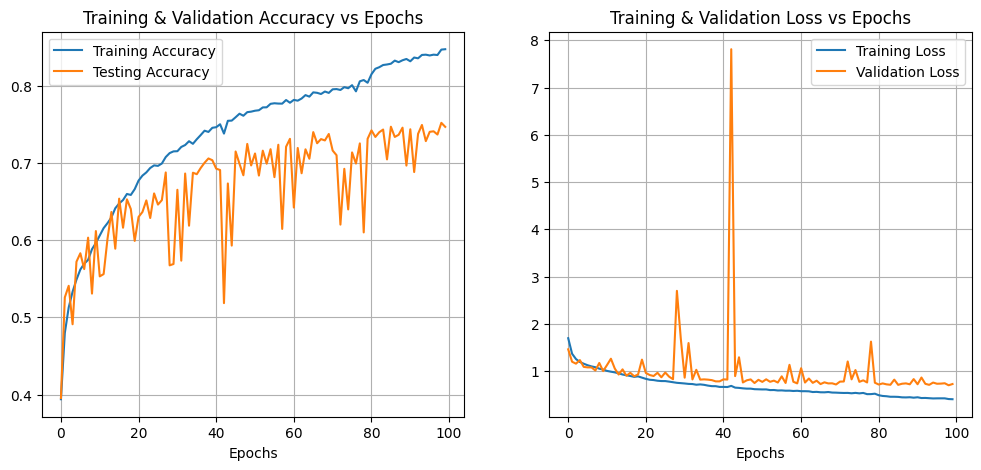

In [12]:
print('Accuracy of the model on test data: ',model.evaluate(test_data,test_labels)[1]*100,'%')
epochs = [i for i in range(100)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs,train_acc,label='Training Accuracy')
plt.plot(epochs,val_acc,label='Testing Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.title('Training & Validation Accuracy vs Epochs')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs,train_loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('Training & Validation Loss vs Epochs')
plt.grid(True)

In [13]:
pred_data = model.predict(test_data)
pred_label = encoder.inverse_transform(pred_data)
actual_label = encoder.inverse_transform(test_labels)

df = pd.DataFrame(columns=['Pred_Labels','Actual_Labels'])
df['Pred_Labels'] = pred_label.flatten()
df['Actual_Labels'] = actual_label.flatten()
df.head(10)

300/300 [==============================] - 1s 2ms/step


,Pred_Labels,Actual_Labels
0,neutral,disgust
1,sad,sad
2,angry,angry
3,sad,sad
4,neutral,neutral
5,disgust,disgust
6,fear,fear
7,happy,fear
8,disgust,disgust
9,sad,sad


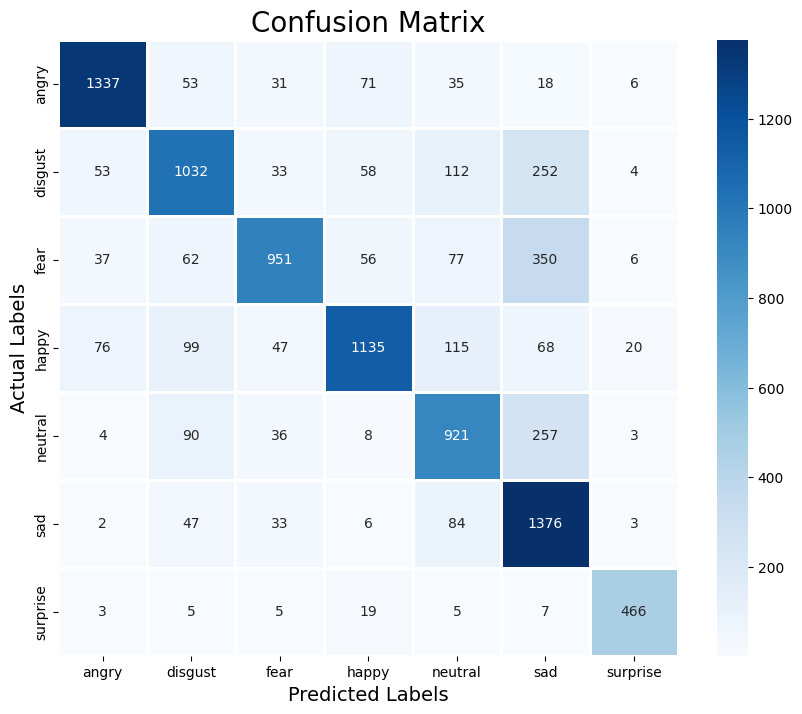

In [14]:
confusion_matrix = confusion_matrix(actual_label, pred_label)
plt.figure(figsize = (10, 8))
confusion_matrix = pd.DataFrame(confusion_matrix , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(confusion_matrix, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [15]:
print(classification_report(actual_label, pred_label))

              precision    recall  f1-score   support

       angry       0.88      0.86      0.87      1551
     disgust       0.74      0.67      0.70      1544
        fear       0.84      0.62      0.71      1539
       happy       0.84      0.73      0.78      1560
     neutral       0.68      0.70      0.69      1319
         sad       0.59      0.89      0.71      1551
    surprise       0.92      0.91      0.92       510

    accuracy                           0.75      9574
   macro avg       0.78      0.77      0.77      9574
weighted avg       0.77      0.75      0.76      9574



======================================================================================================
#### Experimental Model 2: Model Containing Convolutional Layers + Bidirectional LSTM layers
======================================================================================================

We chose this architecture for speech emotion recognition because it combines effective elements. The 1D convolutional layers capture sequential features like pitch, while bidirectional LSTMs understand how emotions unfold over time. Stacked LSTMs refine classifications, and dense layers project features for final predictions. 

In [16]:
model2 = Sequential()

# Add the first convolutional layer
model2.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(train_data.shape[1], 1)))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.3))

# Add the second convolutional layer
model2.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.3))

# Flatten the output to fit the LSTM layers
model2.add(TimeDistributed(Flatten()))

# Bidirectional LSTM Layers
model2.add(Bidirectional(LSTM(256, return_sequences = True, dropout=0.2)))
model2.add(Bidirectional(LSTM(128, return_sequences = True, dropout=0.2)))
model2.add(Bidirectional(LSTM(64, return_sequences = True, dropout=0.2)))

# Flatten the output for the fully connected layers
model2.add(Flatten())


model2.add(Dense(512,activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))



# Output layer
model2.add(Dense(7, activation='softmax'))

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 146, 64)           384       
                                                                 
 batch_normalization_4 (Bat  (None, 146, 64)           256       
 chNormalization)                                                
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 73, 64)            0         
 g1D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 73, 64)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 69, 128)           41088     
                                                                 
 batch_normalization_5 (Bat  (None, 69, 128)          

In [17]:
model_checkpoint = ModelCheckpoint('SER_model_2.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=False)
lr_reduction=ReduceLROnPlateau(monitor='loss',patience=2,verbose=1,factor=0.4,min_lr=0.0000001)
history = model2.fit(train_data,train_labels, epochs = 100, batch_size=64,validation_split=0.15,callbacks=[lr_reduction,model_checkpoint])

Epoch 1/100
509/509 [==============================] - 29s 28ms/step - loss: 1.8592 - accuracy: 0.3099 - val_loss: 1.6069 - val_accuracy: 0.3734 - lr: 0.0010
Epoch 2/100
509/509 [==============================] - 12s 23ms/step - loss: 1.5152 - accuracy: 0.4181 - val_loss: 1.3863 - val_accuracy: 0.4571 - lr: 0.0010
Epoch 3/100
509/509 [==============================] - 12s 23ms/step - loss: 1.3781 - accuracy: 0.4687 - val_loss: 1.2473 - val_accuracy: 0.4985 - lr: 0.0010
Epoch 4/100
509/509 [==============================] - 12s 23ms/step - loss: 1.2928 - accuracy: 0.4971 - val_loss: 1.1781 - val_accuracy: 0.5380 - lr: 0.0010
Epoch 5/100
509/509 [==============================] - 12s 23ms/step - loss: 1.2378 - accuracy: 0.5140 - val_loss: 1.1227 - val_accuracy: 0.5581 - lr: 0.0010
Epoch 6/100
509/509 [==============================] - 11s 22ms/step - loss: 1.1938 - accuracy: 0.5305 - val_loss: 1.2603 - val_accuracy: 0.4806 - lr: 0.0010
Epoch 7/100
509/509 [==============================]

300/300 [==============================] - 3s 8ms/step - loss: 0.8415 - accuracy: 0.7569
Accuracy of the model on test data:  75.69459080696106 %


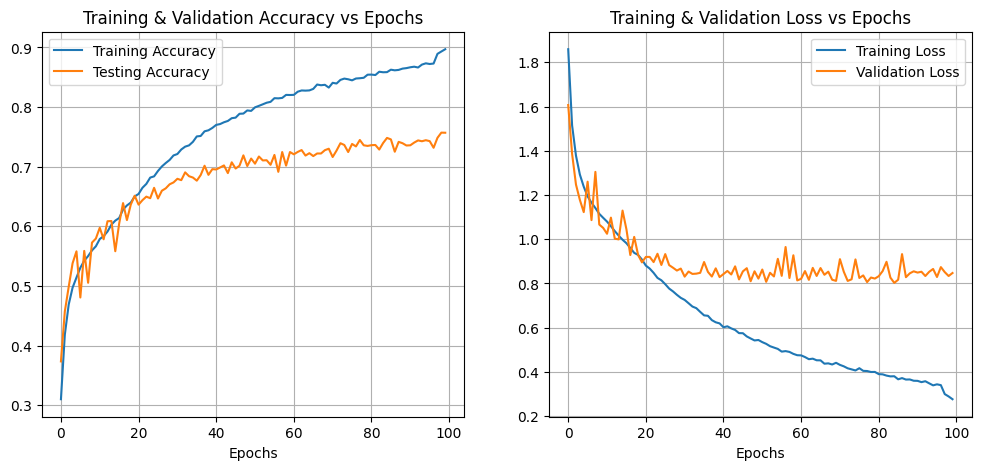

In [18]:
print('Accuracy of the model on test data: ',model2.evaluate(test_data,test_labels)[1]*100,'%')
epochs = [i for i in range(100)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs,train_acc,label='Training Accuracy')
plt.plot(epochs,val_acc,label='Testing Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.title('Training & Validation Accuracy vs Epochs')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs,train_loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('Training & Validation Loss vs Epochs')
plt.grid(True)

In [20]:
pred_data = model2.predict(test_data)
pred_label_1 = encoder.inverse_transform(pred_data)
actual_label_1 = encoder.inverse_transform(test_labels)

df = pd.DataFrame(columns=['Pred_Labels','Actual_Labels'])
df['Pred_Labels'] = pred_label_1.flatten()
df['Actual_Labels'] = actual_label_1.flatten()
df.head(10)

300/300 [==============================] - 2s 8ms/step


,Pred_Labels,Actual_Labels
0,neutral,disgust
1,sad,sad
2,fear,angry
3,sad,sad
4,neutral,neutral
5,disgust,disgust
6,fear,fear
7,sad,fear
8,angry,disgust
9,neutral,sad


In [23]:
pred_data = model2.predict(test_data)
pred_label_1 = encoder.inverse_transform(pred_data)
actual_label_1 = encoder.inverse_transform(test_labels)

df = pd.DataFrame(columns=['Pred_Labels','Actual_Labels'])
df['Pred_Labels'] = pred_label_1.flatten()
df['Actual_Labels'] = actual_label_1.flatten()
df.head(10)

300/300 [==============================] - 2s 7ms/step


,Pred_Labels,Actual_Labels
0,neutral,disgust
1,sad,sad
2,fear,angry
3,sad,sad
4,neutral,neutral
5,disgust,disgust
6,fear,fear
7,sad,fear
8,angry,disgust
9,neutral,sad


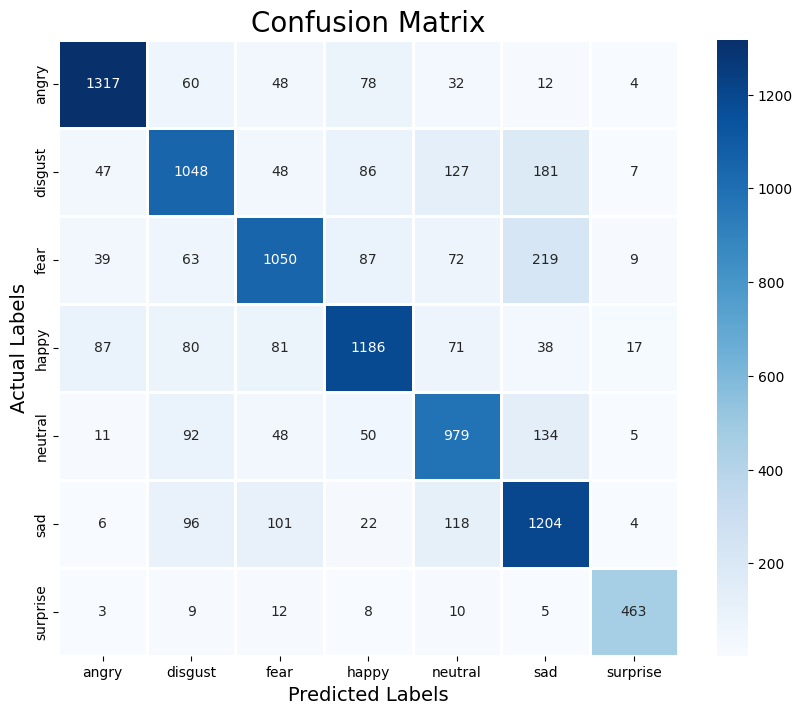

In [26]:
from sklearn.metrics import confusion_matrix
conf_matrix_data = confusion_matrix(actual_label_1, pred_label_1)

# Create a DataFrame for better visualization
labels = [i for i in encoder.categories_[0]]  # Assuming encoder.categories_ is a tuple with one element, adjust if needed
conf_matrix_df = pd.DataFrame(conf_matrix_data, index=labels, columns=labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [27]:
print(classification_report(actual_label, pred_label))

              precision    recall  f1-score   support

       angry       0.88      0.86      0.87      1551
     disgust       0.74      0.67      0.70      1544
        fear       0.84      0.62      0.71      1539
       happy       0.84      0.73      0.78      1560
     neutral       0.68      0.70      0.69      1319
         sad       0.59      0.89      0.71      1551
    surprise       0.92      0.91      0.92       510

    accuracy                           0.75      9574
   macro avg       0.78      0.77      0.77      9574
weighted avg       0.77      0.75      0.76      9574



======================================================================================================
#### Experimental Model 3: Convolutional layers + Bidirectional LSTM layers + MultiHead Attention Layers
======================================================================================================

The proposed speech emotion recognition model blends convolutional layers for local features, bidirectional LSTMs for temporal context, and MultiHead attention for salient parts. Fully connected layers distill high-level representations, leading to accurate multi-class classification of seven emotions.

In [29]:
model3 = Sequential()

# Add the first convolutional layer
model3.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(train_data.shape[1], 1)))
model3.add(BatchNormalization())
model3.add(MaxPooling1D(pool_size=2))
model3.add(Dropout(0.3))

# Add the second convolutional layer
model3.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling1D(pool_size=2))
model3.add(Dropout(0.3))

# Modify the output to fit LSTM layers
model3.add(TimeDistributed(Flatten()))
    
model3.add(Bidirectional(LSTM(128, return_sequences = True, dropout=0.2)))
model3.add(Bidirectional(LSTM(64, return_sequences = True, dropout=0.2)))

# Adding Attention Layer
model3.add(MultiHead(LSTM(128, return_sequences = True, dropout=0.2)))

# Flatten the output for the fully connected layers
model3.add(Flatten())

model3.add(Dense(512,activation = 'relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(256, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))



# Output layer
model3.add(Dense(7, activation='softmax'))

# Compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 146, 64)           384       
                                                                 
 batch_normalization_8 (Bat  (None, 146, 64)           256       
 chNormalization)                                                
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 73, 64)            0         
 g1D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 73, 64)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 69, 128)           41088     
                                                                 
 batch_normalization_9 (Bat  (None, 69, 128)          

In [30]:
model_checkpoint = ModelCheckpoint('SER_model_3.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=False)
lr_reduction=ReduceLROnPlateau(monitor='loss',patience=2,verbose=1,factor=0.4,min_lr=0.0000001)
history = model3.fit(train_data,train_labels, epochs = 100, batch_size=64,validation_split= 0.15,callbacks=[lr_reduction,model_checkpoint])

Epoch 1/100
509/509 [==============================] - 23s 23ms/step - loss: 1.8496 - accuracy: 0.3126 - val_loss: 1.8029 - val_accuracy: 0.2667 - lr: 0.0010
Epoch 2/100
509/509 [==============================] - 10s 19ms/step - loss: 1.5233 - accuracy: 0.4123 - val_loss: 1.4867 - val_accuracy: 0.4115 - lr: 0.0010
Epoch 3/100
509/509 [==============================] - 10s 19ms/step - loss: 1.3945 - accuracy: 0.4601 - val_loss: 1.4035 - val_accuracy: 0.4327 - lr: 0.0010
Epoch 4/100
509/509 [==============================] - 10s 19ms/step - loss: 1.3128 - accuracy: 0.4878 - val_loss: 1.4571 - val_accuracy: 0.4197 - lr: 0.0010
Epoch 5/100
509/509 [==============================] - 10s 19ms/step - loss: 1.2662 - accuracy: 0.5063 - val_loss: 2.3415 - val_accuracy: 0.4251 - lr: 0.0010
Epoch 6/100
509/509 [==============================] - 10s 19ms/step - loss: 1.2310 - accuracy: 0.5154 - val_loss: 1.2728 - val_accuracy: 0.4654 - lr: 0.0010
Epoch 7/100
509/509 [==============================]

300/300 [==============================] - 2s 8ms/step - loss: 0.7080 - accuracy: 0.7671
Accuracy of the model on test data:  76.70775055885315 %


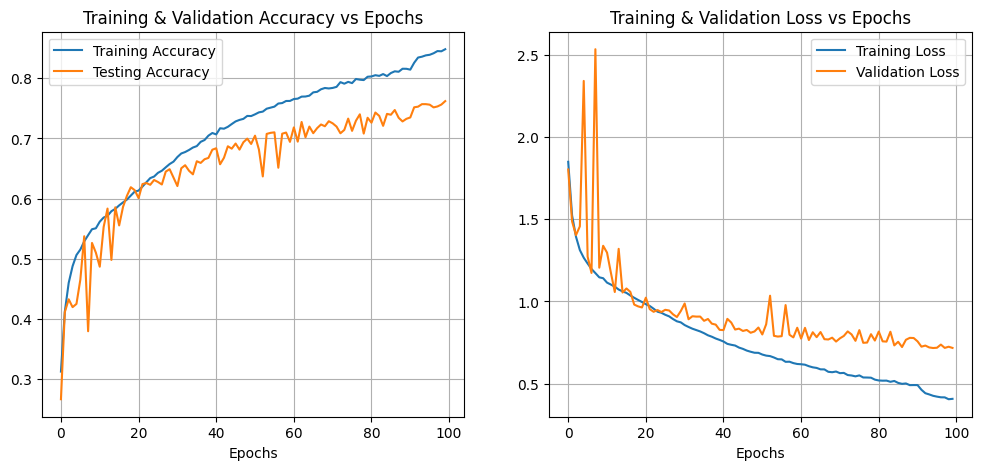

In [31]:
print('Accuracy of the model on test data: ',model3.evaluate(test_data,test_labels)[1]*100,'%')
epochs = [i for i in range(100)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs,train_acc,label='Training Accuracy')
plt.plot(epochs,val_acc,label='Testing Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.title('Training & Validation Accuracy vs Epochs')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs,train_loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('Training & Validation Loss vs Epochs')
plt.grid(True)

In [32]:
pred_data = model3.predict(test_data)
pred_label_1 = encoder.inverse_transform(pred_data)
actual_label_1 = encoder.inverse_transform(test_labels)

df = pd.DataFrame(columns=['Pred_Labels','Actual_Labels'])
df['Pred_Labels'] = pred_label_1.flatten()
df['Actual_Labels'] = actual_label_1.flatten()
df.head(10)

300/300 [==============================] - 4s 7ms/step


,Pred_Labels,Actual_Labels
0,disgust,disgust
1,sad,sad
2,happy,angry
3,sad,sad
4,neutral,neutral
5,disgust,disgust
6,fear,fear
7,fear,fear
8,disgust,disgust
9,sad,sad


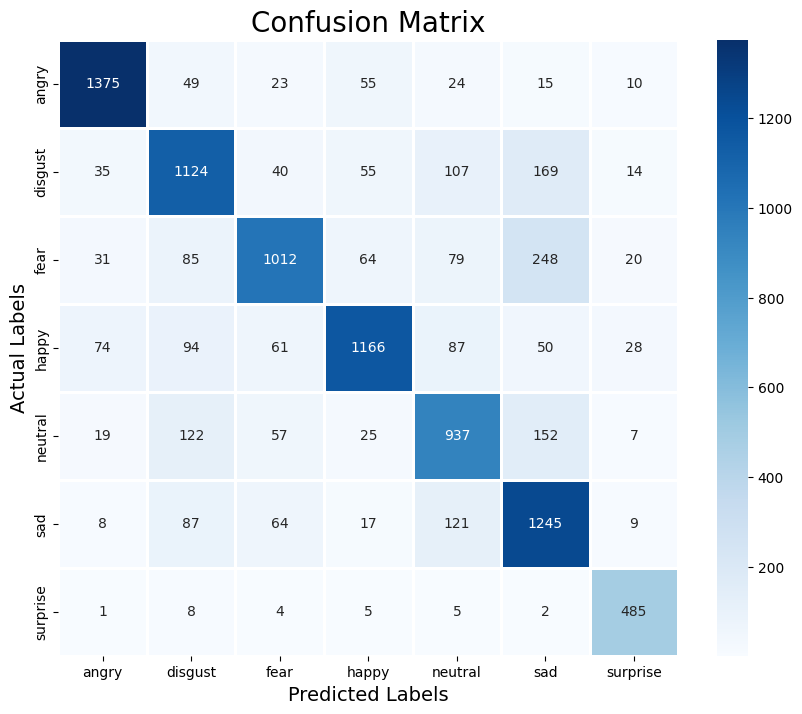

In [35]:
from sklearn.metrics import confusion_matrix
conf_matrix_data = confusion_matrix(actual_label_1, pred_label_1)

# Create a DataFrame for better visualization
labels = [i for i in encoder.categories_[0]]  # Assuming encoder.categories_ is a tuple with one element, adjust if needed
conf_matrix_df = pd.DataFrame(conf_matrix_data, index=labels, columns=labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [36]:
print(classification_report(actual_label_1, pred_label_1))

              precision    recall  f1-score   support

       angry       0.89      0.89      0.89      1551
     disgust       0.72      0.73      0.72      1544
        fear       0.80      0.66      0.72      1539
       happy       0.84      0.75      0.79      1560
     neutral       0.69      0.71      0.70      1319
         sad       0.66      0.80      0.73      1551
    surprise       0.85      0.95      0.90       510

    accuracy                           0.77      9574
   macro avg       0.78      0.78      0.78      9574
weighted avg       0.77      0.77      0.77      9574



======================================================================================================
#### Experimental Model 4: LSTM Layers
======================================================================================================

we thought of implementing this approach with the belief that Bidirectional LSTMs would capture nuanced cues, two stacked BiLSTM layers would progressively extract complex emotional features.

In [37]:
# Reshaping the train Data to fit LSTM layers
reshaped_train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], train_data.shape[2]))
reshaped_train_data.shape

(38294, 150, 1)

In [44]:
# Assuming reshaped_train_data has the shape (38294, 150, 1)
model4 = Sequential()

model4.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(reshaped_train_data.shape[1], reshaped_train_data.shape[2])))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))

model4.add(Bidirectional(LSTM(128, return_sequences=True)))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))

model4.add(Flatten())

model4.add(Dense(512, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))

model4.add(Dense(256, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))

model4.add(Dense(7, activation='softmax'))

# Compile the model
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model4.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirecti  (None, 150, 128)          33792     
 onal)                                                           
                                                                 
 batch_normalization_20 (Ba  (None, 150, 128)          512       
 tchNormalization)                                               
                                                                 
 dropout_20 (Dropout)        (None, 150, 128)          0         
                                                                 
 bidirectional_10 (Bidirect  (None, 150, 256)          263168    
 ional)                                                          
                                                                 
 batch_normalization_21 (Ba  (None, 150, 256)          1024      
 tchNormalization)                                    

In [45]:
model_checkpoint = ModelCheckpoint('SER_model_4.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=False)
lr_reduction = ReduceLROnPlateau(monitor='loss', patience=2, verbose=1, factor=0.4, min_lr=0.0000001)

# Train the model with the callbacks
history = model4.fit(reshaped_train_data, train_labels, epochs=100, batch_size=64, validation_split=0.15, callbacks=[model_checkpoint, lr_reduction])

Epoch 1/100
509/509 [==============================] - 30s 40ms/step - loss: 1.7088 - accuracy: 0.3819 - val_loss: 1.8922 - val_accuracy: 0.3064 - lr: 0.0010
Epoch 2/100
509/509 [==============================] - 19s 37ms/step - loss: 1.3367 - accuracy: 0.4832 - val_loss: 2.1038 - val_accuracy: 0.4066 - lr: 0.0010
Epoch 3/100
509/509 [==============================] - 19s 37ms/step - loss: 1.2126 - accuracy: 0.5243 - val_loss: 1.1574 - val_accuracy: 0.5473 - lr: 0.0010
Epoch 4/100
509/509 [==============================] - 18s 35ms/step - loss: 1.1415 - accuracy: 0.5546 - val_loss: 1.6296 - val_accuracy: 0.3972 - lr: 0.0010
Epoch 5/100
509/509 [==============================] - 19s 37ms/step - loss: 1.0961 - accuracy: 0.5706 - val_loss: 1.0914 - val_accuracy: 0.5793 - lr: 0.0010
Epoch 6/100
509/509 [==============================] - 18s 36ms/step - loss: 1.0521 - accuracy: 0.5884 - val_loss: 1.1082 - val_accuracy: 0.5422 - lr: 0.0010
Epoch 7/100
509/509 [==============================]

300/300 [==============================] - 3s 11ms/step - loss: 1.0073 - accuracy: 0.7799
Accuracy of the model on test data:  77.99248099327087 %


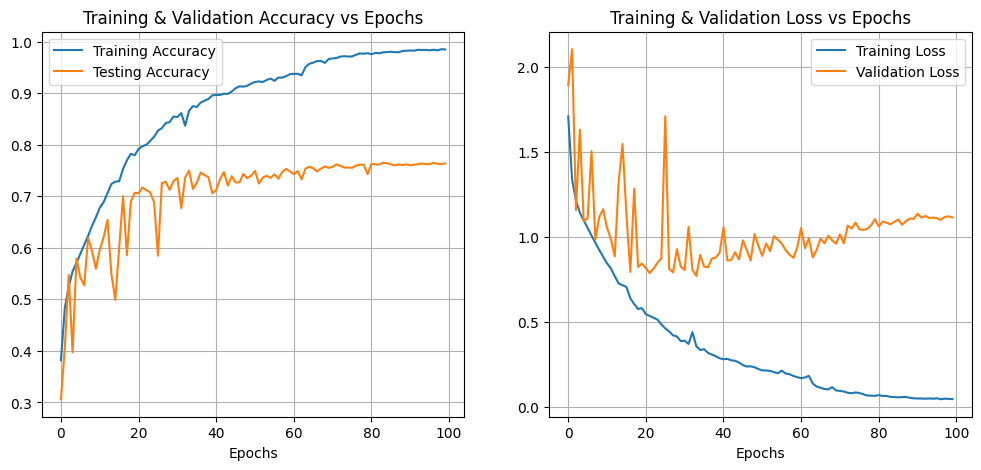

In [46]:
print('Accuracy of the model on test data: ',model4.evaluate(test_data,test_labels)[1]*100,'%')
epochs = [i for i in range(100)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs,train_acc,label='Training Accuracy')
plt.plot(epochs,val_acc,label='Testing Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.title('Training & Validation Accuracy vs Epochs')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs,train_loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('Training & Validation Loss vs Epochs')
plt.grid(True)

#saving the model
# model.save('SER_model.h5')

In [47]:
pred_data = model4.predict(test_data)
pred_label_1 = encoder.inverse_transform(pred_data)
actual_label_1 = encoder.inverse_transform(test_labels)

df = pd.DataFrame(columns=['Pred_Labels','Actual_Labels'])
df['Pred_Labels'] = pred_label_1.flatten()
df['Actual_Labels'] = actual_label_1.flatten()
df.head(10)

300/300 [==============================] - 4s 10ms/step


,Pred_Labels,Actual_Labels
0,neutral,disgust
1,disgust,sad
2,angry,angry
3,sad,sad
4,neutral,neutral
5,disgust,disgust
6,fear,fear
7,fear,fear
8,angry,disgust
9,neutral,sad


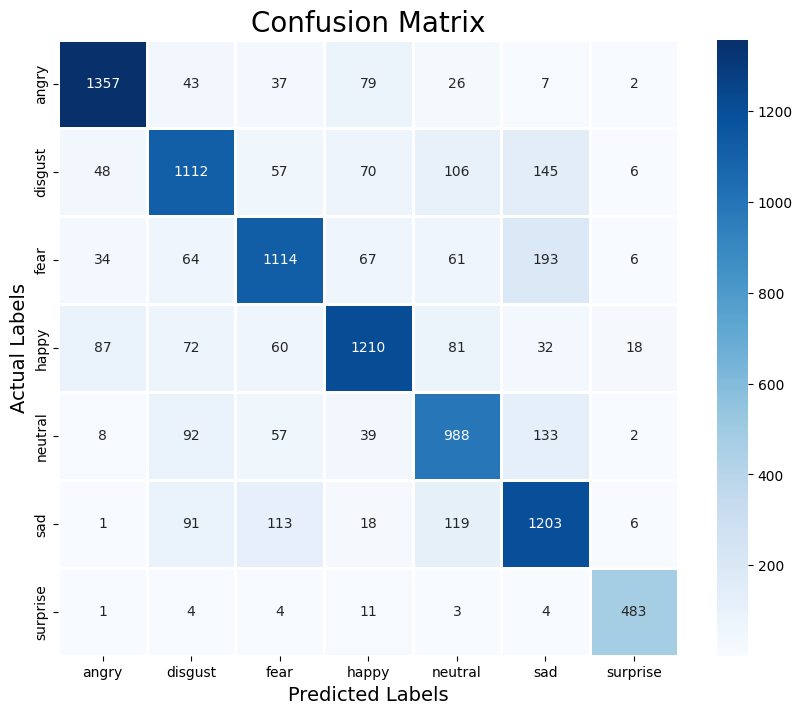

In [51]:
from sklearn.metrics import confusion_matrix

conf_matrix_data = confusion_matrix(actual_label_1, pred_label_1)

# Create a DataFrame for better visualization
labels = [i for i in encoder.categories_[0]]  # Assuming encoder.categories_ is a tuple with one element, adjust if needed
conf_matrix_df = pd.DataFrame(conf_matrix_data, index=labels, columns=labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [50]:
print(classification_report(actual_label_1, pred_label_1))

              precision    recall  f1-score   support

       angry       0.88      0.87      0.88      1551
     disgust       0.75      0.72      0.74      1544
        fear       0.77      0.72      0.75      1539
       happy       0.81      0.78      0.79      1560
     neutral       0.71      0.75      0.73      1319
         sad       0.70      0.78      0.74      1551
    surprise       0.92      0.95      0.94       510

    accuracy                           0.78      9574
   macro avg       0.79      0.80      0.79      9574
weighted avg       0.78      0.78      0.78      9574



======================================================================================================
### Testing on Individual Datasets to compare with Baseline Model
======================================================================================================

In [3]:
Features = pd.read_csv('/kaggle/input/ravdess-features/Features_ravdess_df.csv')
labels=Features['labels']
data= Features.drop('labels',axis= 1)
encoder = OneHotEncoder()
labels = encoder.fit_transform(np.array(labels).reshape(-1,1)).toarray()

# Get the encoding dictionary
encoding_dict = {label: encoded_value for label, encoded_value in zip(encoder.get_feature_names_out(['labels']), encoder.categories_[0])}

print("Encoding Dictionary:")
print(encoding_dict)

Encoding Dictionary:
{'labels_angry': 'angry', 'labels_disgust': 'disgust', 'labels_fear': 'fear', 'labels_happy': 'happy', 'labels_neutral': 'neutral', 'labels_sad': 'sad', 'labels_surprise': 'surprise'}


In [4]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,random_state=0,test_size=0.2,shuffle=True)
train_data.shape,train_labels.shape,test_data.shape,test_labels.shape

((3993, 150), (3993, 7), (999, 150), (999, 7))

In [9]:
neural_network_model = load_model('/kaggle/input/sermodel/SER_model_3.h5', custom_objects={'MultiHead': MultiHead})

pred_data = neural_network_model.predict(test_data)
pred_label_1 = encoder.inverse_transform(pred_data)
actual_label_1 = encoder.inverse_transform(test_labels)

32/32 [==============================] - 0s 2ms/step


In [22]:
print('Accuracy of the model on test data: ',neural_network_model.evaluate(data,labels)[1]*100,'%')

39/39 [==============================] - 0s 3ms/step - loss: 0.8845 - accuracy: 0.8245
Accuracy of the model on test data:  82.45192170143127 %


In [23]:
Features = pd.read_csv('/kaggle/input/tess-dataset/Features_tess_df.csv')
labels=Features['labels']
data= Features.drop('labels',axis= 1)
encoder = OneHotEncoder()
labels = encoder.fit_transform(np.array(labels).reshape(-1,1)).toarray()

# Get the encoding dictionary
encoding_dict = {label: encoded_value for label, encoded_value in zip(encoder.get_feature_names_out(['labels']), encoder.categories_[0])}

print("Encoding Dictionary:")
print(encoding_dict)

Encoding Dictionary:
{'labels_angry': 'angry', 'labels_disgust': 'disgust', 'labels_fear': 'fear', 'labels_happy': 'happy', 'labels_neutral': 'neutral', 'labels_sad': 'sad', 'labels_surprise': 'surprise'}


In [27]:
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,random_state=0,test_size=0.2,shuffle=True)
train_data.shape,train_labels.shape,test_data.shape,test_labels.shape

((8960, 150), (8960, 7), (2240, 150), (2240, 7))

In [28]:
print('Accuracy of the model on test data: ',neural_network_model.evaluate(data,labels)[1]*100,'%')

88/88 [==============================] - 0s 3ms/step - loss: 0.0579 - accuracy: 0.9946
Accuracy of the model on test data:  99.46428537368774 %
